<a href="https://colab.research.google.com/github/maleal2/Assignment-5.1-Object-Detection-/blob/main/MariaLeal_Assignment5_Part_III_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3- Using Webcam Video
Now, we want to use a webcam and make object detection in real time. As you have seen in previous modules, the first step is to have a pre-trained model and use it for future classifications. My recommendation is to use the YOLO8 modell for this part (yolov8n.pt).
Another piece that we need is a script to connect our webcam to Python to make a live object detection application. We will be using the code snippet for Camera Capture which runs JavaScript code to utilize your computer's webcam. Please refer to the previous assignment to copy the code here.
Use a code to detect the camera and take a photo, and finally detect the objects in the photo.

In [ ]:
# Step 1: Installing necessary libraries
!pip install torch torchvision torchaudio
!pip install ultralytics
!pip install ipywidgets

# Step 2: Importing required libraries
import cv2
import numpy as np
import torch
import ipywidgets as widgets
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64
from io import BytesIO
from PIL import Image
from ultralytics import YOLO
import os

# Step 3: Loading pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # YOLOv8 nano model for better performance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 348MB/s]


Image(value=b'', format='jpeg')

<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 couch, 40.3ms
Speed: 16.7ms preprocess, 40.3ms inference, 803.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cup, 1 couch, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 cell phone, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postp

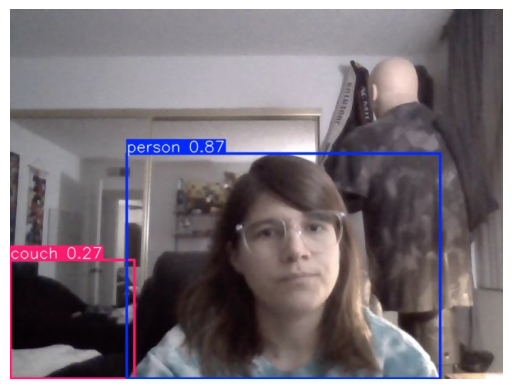

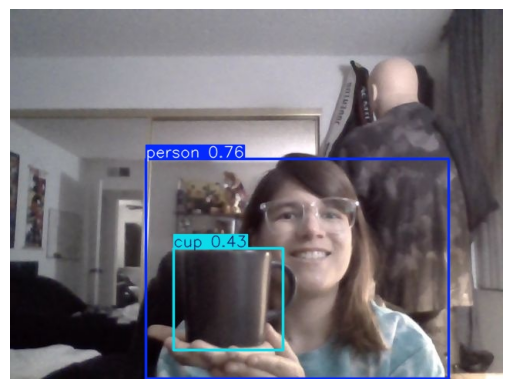

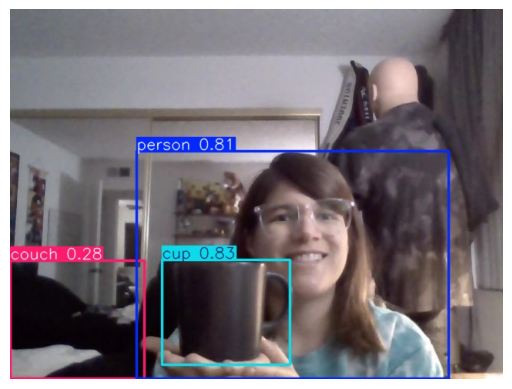

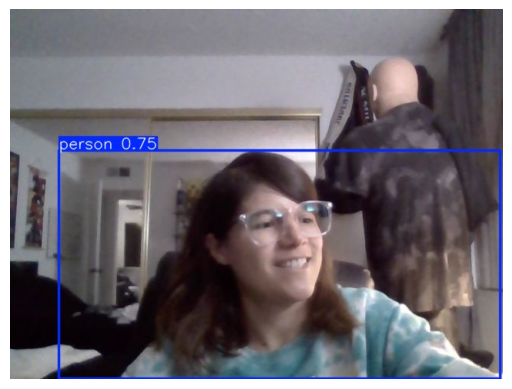

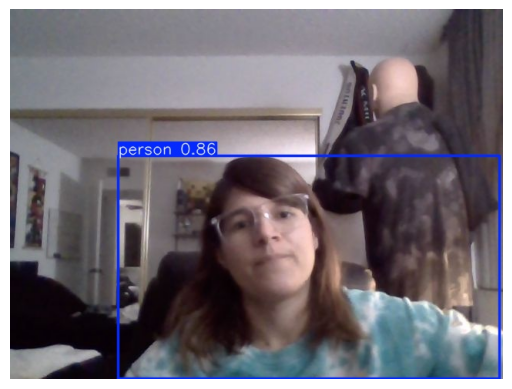

In [ ]:
# Step 4: Function to detect objects using YOLOv8
def detect_objects(frame):
    """Runs YOLOv8 object detection on the provided frame."""
    results = model(frame)
    annotated_frame = results[0].plot()
    return annotated_frame

# Step 5: JavaScript to capture video from webcam
def capture_video():
    display(Javascript('''
        async function captureVideo() {
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');
            const context = canvas.getContext('2d');
            document.body.appendChild(video);
            video.style.display = 'none';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const [track] = stream.getVideoTracks();
            const settings = track.getSettings();
            canvas.width = settings.width;
            canvas.height = settings.height;

            async function stopVideo() {
                stream.getTracks().forEach(track => track.stop());
                video.remove();
                canvas.remove();
            }

            window.stopVideo = stopVideo;

            while (true) {
                context.drawImage(video, 0, 0, canvas.width, canvas.height);
                const imageData = canvas.toDataURL('image/jpeg', 0.8);
                const response = await google.colab.kernel.invokeFunction('notebook.getFrame', [imageData], {});
                if (response.data.result === 'quit') break;
                await new Promise((resolve) => setTimeout(resolve, 100));
            }

            stream.getTracks().forEach(track => track.stop());
            video.remove();
            canvas.remove();
        }
        captureVideo();
    '''))

# Step 6: Initializing output directories and variables
frames_dir = "/content/video_frames"
os.makedirs(frames_dir, exist_ok=True)

output_video_path = "/content/captured_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_rate = 10
video_writer = None
stop_capture = False  # Flag to stop video capture

# Step 7: Python callback to process frames
def get_frame(image_data):
    global video_writer, stop_capture
    try:
        if stop_capture:
            return {'result': 'quit'}

        # Decoding the frame
        image_data = image_data.split(",")[1]
        image_bytes = base64.b64decode(image_data)
        image = Image.open(BytesIO(image_bytes))
        frame = np.array(image)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detecting objects in the frame
        frame_detected = detect_objects(frame_rgb)

        # Saving the frame as an image
        frame_number = len(os.listdir(frames_dir)) + 1
        frame_path = os.path.join(frames_dir, f"frame_{frame_number:04d}.jpg")
        cv2.imwrite(frame_path, frame_detected)

        # Initializing video writer if not done yet
        if video_writer is None:
            height, width, _ = frame_detected.shape
            video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

        # Writing the frame to the video
        video_writer.write(cv2.cvtColor(frame_detected, cv2.COLOR_BGR2RGB))
        return {'result': 'continue'}
    except Exception as e:
        print(f"Error processing frame: {e}")
        return {'result': 'error'}

# Registering the Python callback function
from google.colab import output
output.register_callback('notebook.getFrame', get_frame)

# Step 8: Widget to display the video stream
image_widget = widgets.Image(format='jpeg')
display(image_widget)

# Step 9: Stopping button functionality
def stop_video(change):
    global video_writer, stop_capture
    stop_capture = True
    eval_js('window.stopVideo()')  # Stopping JavaScript video stream
    print("Video stream stopped!")

    # Releasing the video writer
    if video_writer is not None:
        video_writer.release()
        print(f"Video saved to: {output_video_path}")

    # Displaying saved frames
    print("Displaying saved frames:")
    for img_file in sorted(os.listdir(frames_dir))[:5]:  # Displaying first 5 frames
        img = cv2.imread(os.path.join(frames_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        from matplotlib import pyplot as plt
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Step 10: Add a stop button
stop_button = widgets.Button(description="Stop Video", button_style="danger")
stop_button.on_click(stop_video)
display(widgets.VBox([stop_button, widgets.Label("Starting video capture. Click the stop button to stop the video stream.")]))

# Step 11: Start capturing video
capture_video()

**Observations**:

- From the above results, we can see the real-time detection of objects from my camera. The real-time video streaming display on the Colab notebook is possible by using `ipywidgets.Image`

- The `detect_objects` function applies the YOLOv8 model to each frame, annotates it with detected objects, and updates the display widget in real time.

- Additionally, I proceeded to add a stop video buttom to manually end the real-time video feed.

# Conclusions


**Part I : Video/Reading**

**a) Metadata Extraction**

- I successfully extracted metadata from the Bangkok.mpa video, including properties such as resolution, frame rate, and duration.

**b) Video Playback using OpenCV (Method -I)**

- During the playing of the Bangkok.mp4 video on OpenCV, it was encountered the "Buffered data was truncated after reaching the output size limit" error when attempting to display video frames in the Colab notebook.

**Observations:**
- The issue occurred because the notebook interface struggled to handle the large frames.
- To mitigate this:
- It is recommended to resize the video frames using cv2.resize to reduce their resolution or,
- To Limit the number of displayed frames to reduce output size.

**HTML-based Video Playback (Method -II)**

- The same .mp4 video was played using HTML, which was simpler and ran seamlessly in the notebook without size constraints.

**Video Conversion to x264 Format**

- The same .mp4 video faced compatibility issues with the x264 codec in Colab due to its limitations.
- Then, it was followed the suggested workaround from Detectron2 GitHub Issue #2901, switching the codec to mp4v.
- After applying the fix, it successfully converted and saved the video in the desired format, enabling smooth video captures using OpenCV.

**c) Grayscale Frame Capture**

- It was captured the first three frames of the video in grayscale.

**Part 2: Pose Estimation in Video**

- It was performed a pose estimation using the dance.gif file as input.
- TensorFlow Hub's MoveNet model (movenet_lightning) was used for keypoint detection,  and calculated poses for each frame.
- The results were successsfully visualized  as an animated GIF, showing detected keypoints overlaid on the dancing figure.

**Part 3: Real-time Object Detection with Webcam**

- Real-time object detection using YOLOv8 and webcam integration.
- The basic requirements were enhanced by enabling object detection directly on the video stream for extra credit.
- Keyroles for enabling object detection were the follwowing:

1. Capturing video from the webcam using JavaScript and Python integration in Colab.
2. Integrating  YOLOv8 for real-time object detection.
3. Processing  video frames to display detections live in the notebook.
4. Ensuring functionality by saving the captured video and displaying a few frames as proof of the process, even after stopping the runtime.